In [22]:
import sys
try:
    from ompl import util as ou
    from ompl import base as ob
    from ompl import geometric as og
except ImportError:
    # if the ompl module is not in the PYTHONPATH assume it is installed in a
    # subdirectory of the parent directory called "py-bindings."
    from os.path import abspath, dirname, join
    sys.path.insert(0, join(dirname(dirname(abspath(__file__))), 'py-bindings'))
    from ompl import util as ou
    from ompl import base as ob
    from ompl import geometric as og
from math import sqrt
import argparse

## @cond IGNORE
# Our "collision checker". For this demo, our robot's state space
# lies in [0,1]x[0,1], with a circular obstacle of radius 0.25
# centered at (0.5,0.5). Any states lying in this circular region are
# considered "in collision".
class ValidityChecker(ob.StateValidityChecker):
    def __init__(self, si, min_distance):
        super(ValidityChecker, self).__init__(si)
        self.min_distance = min_distance
    # Returns whether the given state's position overlaps the
    # circular obstacle
    def isValid(self, state):
        return self.clearance(state) > self.min_distance

    # Returns the distance from the given state's position to the
    # boundary of the circular obstacle.
    def clearance(self, state):
        # Extract the robot's (x,y) position from its state
        x = state[0]
        y = state[1]
        z = state[2]

        # Distance formula between three points, offset by the circle's
        # radius
        return sqrt((x - 0.5)**2 + (y - 0.5)**2 + (z - 0.5)**2) - 0.05


## Returns a structure representing the optimization objective to use
#  for optimal motion planning. This method returns an objective
#  which attempts to minimize the length in configuration space of
#  computed paths.
def getPathLengthObjective(si):
    return ob.PathLengthOptimizationObjective(si)

## Returns an optimization objective which attempts to minimize path
#  length that is satisfied when a path of length shorter than 1.51
#  is found.
def getThresholdPathLengthObj(si):
    obj = ob.PathLengthOptimizationObjective(si)
    obj.setCostThreshold(ob.Cost(1.51))
    return obj

## Defines an optimization objective which attempts to steer the
#  robot away from obstacles. To formulate this objective as a
#  minimization of path cost, we can define the cost of a path as a
#  summation of the costs of each of the states along the path, where
#  each state cost is a function of that state's clearance from
#  obstacles.
#
#  The class StateCostIntegralObjective represents objectives as
#  summations of state costs, just like we require. All we need to do
#  then is inherit from that base class and define our specific state
#  cost function by overriding the stateCost() method.
#
class ClearanceObjective(ob.StateCostIntegralObjective):
    def __init__(self, si):
        super(ClearanceObjective, self).__init__(si, True)
        self.si_ = si

    # Our requirement is to maximize path clearance from obstacles,
    # but we want to represent the objective as a path cost
    # minimization. Therefore, we set each state's cost to be the
    # reciprocal of its clearance, so that as state clearance
    # increases, the state cost decreases.
    def stateCost(self, s):
        return ob.Cost(1 / (self.si_.getStateValidityChecker().clearance(s) +
                            sys.float_info.min))

## Return an optimization objective which attempts to steer the robot
#  away from obstacles.
def getClearanceObjective(si):
    return ClearanceObjective(si)

## Create an optimization objective which attempts to optimize both
#  path length and clearance. We do this by defining our individual
#  objectives, then adding them to a MultiOptimizationObjective
#  object. This results in an optimization objective where path cost
#  is equivalent to adding up each of the individual objectives' path
#  costs.
#
#  When adding objectives, we can also optionally specify each
#  objective's weighting factor to signify how important it is in
#  optimal planning. If no weight is specified, the weight defaults to
#  1.0.
def getBalancedObjective1(si):
    lengthObj = ob.PathLengthOptimizationObjective(si)
    clearObj = ClearanceObjective(si)

    opt = ob.MultiOptimizationObjective(si)
    opt.addObjective(lengthObj, 5.0)
    opt.addObjective(clearObj, 1.0)

    return opt

## Create an optimization objective equivalent to the one returned by
#  getBalancedObjective1(), but use an alternate syntax.
#  THIS DOESN'T WORK YET. THE OPERATORS SOMEHOW AREN'T EXPORTED BY Py++.
# def getBalancedObjective2(si):
#     lengthObj = ob.PathLengthOptimizationObjective(si)
#     clearObj = ClearanceObjective(si)
#
#     return 5.0*lengthObj + clearObj


## Create an optimization objective for minimizing path length, and
#  specify a cost-to-go heuristic suitable for this optimal planning
#  problem.
def getPathLengthObjWithCostToGo(si):
    obj = ob.PathLengthOptimizationObjective(si)
    obj.setCostToGoHeuristic(ob.CostToGoHeuristic(ob.goalRegionCostToGo))
    return obj


# Keep these in alphabetical order and all lower case
def allocatePlanner(si, plannerType):
    if plannerType.lower() == "bfmtstar":
        return og.BFMT(si)
    elif plannerType.lower() == "bitstar":
        return og.BITstar(si)
    elif plannerType.lower() == "fmtstar":
        return og.FMT(si)
    elif plannerType.lower() == "informedrrtstar":
        return og.InformedRRTstar(si)
    elif plannerType.lower() == "prmstar":
        return og.PRMstar(si)
    elif plannerType.lower() == "rrtstar":
        return og.RRTstar(si)
    elif plannerType.lower() == "sorrtstar":
        return og.SORRTstar(si)
    else:
        ou.OMPL_ERROR("Planner-type is not implemented in allocation function.")


# Keep these in alphabetical order and all lower case
def allocateObjective(si, objectiveType):
    if objectiveType.lower() == "pathclearance":
        return getClearanceObjective(si)
    elif objectiveType.lower() == "pathlength":
        return getPathLengthObjective(si)
    elif objectiveType.lower() == "thresholdpathlength":
        return getThresholdPathLengthObj(si)
    elif objectiveType.lower() == "weightedlengthandclearancecombo":
        return getBalancedObjective1(si)
    else:
        ou.OMPL_ERROR("Optimization-objective is not implemented in allocation function.")



def plan(runTime, plannerType, objectiveType, fname, interpolationnumber, min_distance, start, goal):
    # Construct the robot state space in which we're planning. We're
    # planning in [0,1]x[0,1]x[0,1], a subset of R^3.
    

    # Set the bounds of space to be in [-1,1].
    space.setBounds(-0.85, 0.85)

    # Construct a space information instance for this state space
    si = ob.SpaceInformation(space)

    # Set the object used to check which states in the space are valid
    validityChecker = ValidityChecker(si, min_distance)
    si.setStateValidityChecker(validityChecker)

    si.setup()
    

    # Create a problem instance
    pdef = ob.ProblemDefinition(si)

    # Set the start and goal states
    pdef.setStartAndGoalStates(start, goal)

    # Create the optimization objective specified by our command-line argument.
    # This helper function is simply a switch statement.
    pdef.setOptimizationObjective(allocateObjective(si, objectiveType))

    # Construct the optimal planner specified by our command line argument.
    # This helper function is simply a switch statement.
    optimizingPlanner = allocatePlanner(si, plannerType)

    # Set the problem instance for our planner to solve
    optimizingPlanner.setProblemDefinition(pdef)
    optimizingPlanner.setup()

    # attempt to solve the planning problem in the given runtime
    solved = optimizingPlanner.solve(runTime)

    if solved:
        path = pdef.getSolutionPath()
        path.interpolate(interpolationnumber)
        
        # Output the length of the path found
        print('{0} found solution of path length {1:.4f} with an optimization ' \
            'objective value of {2:.4f}'.format( \
            optimizingPlanner.getName(), \
            pdef.getSolutionPath().length(), \
            pdef.getSolutionPath().cost(pdef.getOptimizationObjective()).value()))

        # If a filename was specified, output the path as a matrix to
        # that file for visualization
        if fname:
            with open(fname, 'w') as outFile:
                outFile.write(pdef.getSolutionPath().printAsMatrix())
        
        path_states = pdef.getSolutionPath().getStates()
        points = [[s[0], s[1], s[2]] for s in path_states]
        return points
    else:
        print("No solution found.")

if __name__ == "__main__":
    runtime = 2.0
    plannerType = "RRTstar"
    objectiveType = "PathLength"
    filename = "output.txt" # oder z.B. "path_output.txt"
    interpolationnumber = 20
    min_distance = 0.01

    space = ob.RealVectorStateSpace(3)
    # Set our robot's starting state to be the bottom-left corner of
    # the environment, or (0,0).
    start = ob.State(space)
    start[0] = 0.1
    start[1] = 0.1
    start[2] = 0.85

    # Set our robot's goal state to be the top-right corner of the
    # environment, or (1,1).
    goal = ob.State(space)
    goal[0] = 0.65
    goal[1] = 0.3
    goal[2] = 0.4
    
    points = plan(runtime, plannerType, objectiveType, filename, interpolationnumber, min_distance, start, goal)
    
    print(points)
## @endcond

Debug:   RRTstar: Planner range detected to be 0.588897
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 45
Info:    RRTstar: Found an initial solution with a cost of 0.81 in 3 iterations (4 vertices in the graph)
RRTstar found solution of path length 0.7426 with an optimization objective value of 0.7426
Info:    RRTstar: Created 2716 new states. Checked 1150625 rewire options. 1 goal states in tree. Final solution cost 0.743
[[0.1, 0.1, 0.85], [0.12933758072545565, 0.10798894384034674, 0.8326933626013684], [0.15867516145091126, 0.11597788768069349, 0.8153867252027368], [0.1880127421763669, 0.12396683152104024, 0.7980800878041052], [0.21735032290182255, 0.13195577536138697, 0.7807734504054735], [0.2466879036272782, 0.13994471920173374, 0.7634668130068419], [0.2760254843527338, 0.14793366304208044, 0.7461601756082104], [0.30536306507818944, 0.1559226068824272, 0.7288535382095788], [0.334082809655007, 0

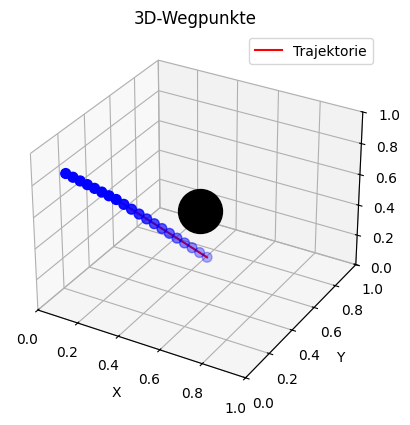

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Listen entpacken
xs, ys, zs = zip(*points)

# Plot vorbereiten
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Linie + Punkte
ax.plot(xs, ys, zs, color='red', label='Trajektorie')
ax.scatter(xs, ys, zs, color='blue', s=50)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.scatter(0.5, 0.5, 0.5, color='black' , s =1000)

# Achsenbeschriftung
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D-Wegpunkte")
ax.legend()
ax.grid(True)


plt.show()

In [24]:
import numpy as np

def load_waypoints():
    # Wegpunkte aus Datei laden
    waypoints = []
    with open("output.txt", "r") as f:
        for line in f:
            if line.strip():
                x, y, z = map(float, line.strip().split())
                waypoints.append(np.array([x, y, z]))
    return waypoints
    print(waypoints)
print(load_waypoints())

[array([0.1 , 0.1 , 0.85]), array([0.129338, 0.107989, 0.832693]), array([0.158675, 0.115978, 0.815387]), array([0.188013, 0.123967, 0.79808 ]), array([0.21735 , 0.131956, 0.780773]), array([0.246688, 0.139945, 0.763467]), array([0.276025, 0.147934, 0.74616 ]), array([0.305363, 0.155923, 0.728854]), array([0.334083, 0.167929, 0.701449]), array([0.362803, 0.179936, 0.674045]), array([0.391522, 0.191942, 0.64664 ]), array([0.420242, 0.203948, 0.619236]), array([0.448962, 0.215955, 0.591831]), array([0.477682, 0.227961, 0.564427]), array([0.506401, 0.239968, 0.537022]), array([0.535121, 0.251974, 0.509618]), array([0.563841, 0.263981, 0.482213]), array([0.592561, 0.275987, 0.454809]), array([0.62128 , 0.287994, 0.427404]), array([0.65, 0.3 , 0.4 ])]


In [31]:
def interpolate_trajectory(anglelist, steps_per_segment=20):
    interpolated = []
    for i in range(len(anglelist) - 1):
        start = np.array(anglelist[i])
        end = np.array(anglelist[i + 1])
        segment = np.linspace(start, end, steps_per_segment, endpoint=False)
        interpolated.extend(segment)
    interpolated.append(anglelist[-1])  # letzter Punkt anhängen
    return np.array(interpolated)


In [59]:
import numpy as np
from ikpy.chain import Chain
from ikpy.link import URDFLink

joint_limits_min = np.array([-166, -101, -166, -176, -166, -1, -166])
joint_limits_max = np.array([166, 101, 166, -4, 166, 215, 166])
lims_min_safe = joint_limits_min + 1
lims_max_safe = joint_limits_max -1
joint_limits_rad_min = np.radians(lims_min_safe) 
joint_limits_rad_max = np.radians(lims_max_safe) 

franka_chain = Chain.from_urdf_file(
    "franka.urdf",
    base_elements=["panda_panda_link0"],
    active_links_mask = [False, True, True, True, True, True, True, True, False, False, False]
)
#set bounds
for i in range(len(joint_limits_rad_min)):
    franka_chain.links[i + 1].bounds = (joint_limits_rad_min[i], joint_limits_rad_max[i])

positions = load_waypoints()
anglelist = []
prev_angle =  [-0.53245615, -0.38066329, 0.26839613, -0.88636377, 0.77729231, 0.09430391, 0.00391651, 0.79768890]
for target_position in positions:
    target_frame = np.eye(4)
    target_frame[:3, :3] = np.array([
        [1,  0,  0],  # X zeigt in X
        [0, -1,  0],  # Y zeigt in -Y
        [0,  0, -1]   # Z zeigt nach unten
    ])
    target_frame[:3, 3] = target_position

    # Expand 7 DOF angle list to full joint vector
    full_prev_angle = franka_chain.active_to_full(prev_angle, np.zeros(len(franka_chain.links)))
    
    # Run IK
    angles = franka_chain.inverse_kinematics_frame(target_frame, initial_position=full_prev_angle)

    # Extract only active joints for the next iteration
    prev_angle = franka_chain.active_from_full(angles)

    fki=franka_chain.forward_kinematics(angles)
    anglelist.append(prev_angle)
    inter_traj = interpolate_trajectory(anglelist)
    np.save("joint_angles.npy", inter_traj)

for row in anglelist:
    print("            [" + ", ".join(f"{float(v):.8f}" for v in row) + "],")
print("")
for row in inter_traj:
    print("            [" + ", ".join(f"{float(v):.8f}" for v in row) + "],")

print(fki)

            [-0.53245615, -0.38066329, 0.26839613, -0.88636377, 0.77729231, 0.09430391, 0.00391651],
            [-0.63421651, -0.39263074, 0.38296749, -0.96076465, 0.66462940, 0.12375652, 0.07433424],
            [-0.62764268, -0.36397611, 0.45981717, -1.03131039, 0.63270949, 0.15370722, 0.05418956],
            [-0.62834959, -0.33163804, 0.52467933, -1.08917596, 0.61805243, 0.20059961, 0.05418893],
            [-0.63646594, -0.29727886, 0.58528277, -1.13406047, 0.60482725, 0.26314365, 0.07362470],
            [-0.65577593, -0.26111692, 0.64978855, -1.16739901, 0.58871437, 0.33640180, 0.05920757],
            [-0.68237460, -0.22313202, 0.71432083, -1.19676878, 0.58189589, 0.41814958, 0.04411204],
            [-0.71119045, -0.18285794, 0.77797644, -1.22399599, 0.57942580, 0.50872874, 0.02309152],
            [-0.69999565, -0.13322097, 0.82534609, -1.28189723, 0.56980113, 0.60601124, -0.04002216],
            [-0.69009405, -0.07860422, 0.86843306, -1.33186619, 0.55838995, 0.71532323, 0.

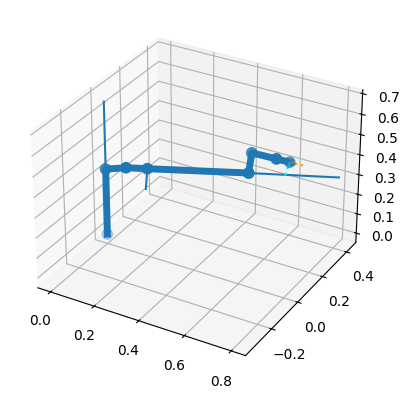

In [6]:
import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D
ax = matplotlib.pyplot.figure().add_subplot(111, projection='3d')

franka_chain.plot(angles, ax)
matplotlib.pyplot.show()

In [7]:
# objekte in simulation/ andere objekte in pfadplanung
# mehr Pfadpunkte kalkulieren
# TCP nach unten gerichtet
# Kolision von Roboter vermeiden
# pick and place komplett modellieren
# statt txt export mit Api arbeiten


In [8]:
import numpy as np
from ikpy.chain import Chain
from ikpy.link import URDFLink

joint_limits_min = np.array([-166, -101, -166, -176, -166, -1, -166])
joint_limits_max = np.array([166, 101, 166, -4, 166, 215, 166])

joint_limits_rad_min = np.radians(joint_limits_min) 
joint_limits_rad_max = np.radians(joint_limits_max) 

panda_chain = Chain(name='panda_arm', links=[
    URDFLink(
        name="link1",
        bounds=(joint_limits_rad_min[0],joint_limits_rad_max[0]),
        origin_translation=np.array([0.0, 0.0, 0.333]),
        origin_orientation=np.array([0.0, -1.5707963, 0.0]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link2",
        bounds=(joint_limits_rad_min[1],joint_limits_rad_max[1]),
        origin_translation=np.array([0.0000003, 0.0000001, 0.0]),
        origin_orientation=np.array([0.0, 0.0, 1.5707964]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link3",
        bounds=(joint_limits_rad_min[2],joint_limits_rad_max[2]),
        origin_translation=np.array([-0.0000001, -0.3159997, 0.0]),
        origin_orientation=np.array([-0.0000002, -0.0000002, -1.5707958]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link4",
        bounds=(joint_limits_rad_min[3],joint_limits_rad_max[3]),
        origin_translation=np.array([0.0, -0.0000001, -0.0824999]),
        origin_orientation=np.array([-0.0000002, 0.0000002, -1.5707968]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link5",
        bounds=(joint_limits_rad_min[4],joint_limits_rad_max[4]),
        origin_translation=np.array([0.0000005, 0.3839998, 0.0824996]),
        origin_orientation=np.array([-0.0000003, 0.0000001, 1.5707946]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link6",
        bounds=(joint_limits_rad_min[5],joint_limits_rad_max[5]),
        origin_translation=np.array([0.0000005, 0.0000003, 0.0000002]),
        origin_orientation=np.array([0.0000001, 0.0000003, -1.5707946]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link7",
        bounds=(joint_limits_rad_min[6],joint_limits_rad_max[6]),
        origin_translation=np.array([-0.0000002, -0.0000005, -0.0879998]),
        origin_orientation=np.array([0.0, 0.0, -1.5707996]),
        rotation=np.array([1, 0, 0]),
    ),
])

positions = load_waypoints()
anglelist = []
prev_angle = [0.09519244, -0.86469131, -0.00999133, -1.47917473, 0.00002117, 0.48928735, 0.00000000]
for target_position in positions:
    
    R = np.array([
        [1,  0,  0],
        [0,  0,  1],
        [0, -1,  0]
    ])
    target_frame = np.eye(4)
    target_frame[:3, :3] = R
    target_frame[:3, 3] = target_position
    angles = panda_chain.inverse_kinematics_frame(target_frame, initial_position=prev_angle)
    prev_angle = angles
    # joint_limits_min = np.array([-166, -101, -166, -176, -166, -1, -166])
    # joint_limits_max = np.array([166, 101, 166, -4, 166, 215, 166])
    # # Sicherheitsmarge in Grad
    # safety_margin_deg = 2.0
    # safety_margin_rad = np.radians(safety_margin_deg)
    
    # joint_limits_rad_min = np.radians(joint_limits_min) + safety_margin_rad
    # joint_limits_rad_max = np.radians(joint_limits_max) - safety_margin_rad
    
    # # Sicherstellen, dass min < max nach Abzug/Addition der Margin
    # joint_limits_rad_min = np.minimum(joint_limits_rad_min, joint_limits_rad_max - 1e-3)
    
    # angles_clipped = np.clip(angles, joint_limits_rad_min, joint_limits_rad_max)

    # # Prüfen, ob ein Wert verändert wurde
    # if not np.allclose(angles, angles_clipped, atol=1e-6):
    #     print("Warning: Clipping occurred!")
    #     print("  Original angles: ", np.round(angles, 6))
    #     print("  Clipped angles:  ", np.round(angles_clipped, 6))
    # else:
    #     print("All joint angles within limits.")

    # print(" ") 
    forward_k=panda_chain.forward_kinematics(angles)
    anglelist.append(angles)


for row in anglelist:
    print("            [" + ", ".join(f"{float(v):.8f}" for v in row) + "],")

print(forward_k)

            [0.43956379, -1.69485928, 2.00889569, -1.20566930, -2.86781734, 0.43302578, 0.00000000],
            [0.61601928, -1.66266380, 2.01144233, -1.61705158, -2.89724647, 0.04199618, 0.00000000],
            [0.78508070, -1.54854590, 2.08062085, -2.00513070, -2.86561965, 0.07451756, 0.00000000],
            [0.94868831, -1.55854146, 2.09964923, -2.29725870, -2.75613787, 0.07551685, 0.00000000],
            [0.97546877, -1.43940584, 2.11282239, -2.51448135, -2.89724647, 0.05659800, 0.00000000],
            [1.00584893, -1.37464884, 2.12619552, -2.70274850, -2.89130132, 0.05136406, 0.00000000],
            [0.99433579, -1.28517960, 2.13783328, -2.87439261, -2.89721242, 0.05052110, 0.00000000],
            [0.94674781, -1.32576541, 2.35790534, -2.91483796, -2.00573463, 0.02145664, 0.00000000],
            [0.79485374, -1.22782022, 2.44230371, -2.97175831, -1.62986980, 0.06283833, 0.00000000],
            [0.56267281, -1.23493140, 2.48754394, -3.00653864, -1.39058897, -0.01636517, 0.

In [9]:
import pinocchio as pin
from example_robot_data import load

robot = load("ur5")  # Auch verfügbar: "talos", "panda", "icub", etc.
model = robot.model
data = model.createData()

q0 = robot.q0
pin.forwardKinematics(model, data, q0)
placement = data.oMi[model.getFrameId("tool0")]  # Endeffektor-Frame

print("TCP-Position:", placement.translation)


IndexError: Index out of range

In [ ]:
from ikpy.chain import Chain

franka_chain = Chain.from_urdf_file("franka.urdf")
print(franka_chain)

# Target position in Cartesian coordinates (x, y, z)
target_position = [0.5, 0.0, 0.5]

#joint_angles = franka_chain.inverse_kinematics(target_position)

#print("Joint angles for target position:", joint_angles)